# 匯入套件、讀檔

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter('ignore')

In [2]:
data = pd.read_excel("for_model_考慮變動量.xlsx")

In [3]:
data.fillna(0, inplace=True)

刪除碳排為零的資料 = data[(data['總碳排量'] == 0)].index
data = data.drop(刪除碳排為零的資料, inplace=False)

In [4]:
#修正名稱中空白、換行的格式
data.columns = data.columns.str.replace(" ", "")
data.columns = data.columns.str.replace("\n", "")

#針對產業別中的文字空白與換行問題
data["產業別"] = data["產業別"].replace(r'\n', '', regex=True)
data["產業別"] = data["產業別"].replace(r' ', '', regex=True)

In [5]:
產業別 = data["產業別"]

In [6]:
data.columns

Index(['Unnamed:0', '公司代號', '公司名稱', '產業別', '年', '總碳排量', '生產量', '存貨',
       '不動產廠房及設備', '商譽及無形資產合計', '預付投資款', '應付帳款及票據', '普通股股本', '資本公積合計', '營業成本',
       '營業費用', '研究發展費', '處分不動產廠房設備（含預付）－CFI', '折舊－CFO', '攤提－CFO',
       '購置不動產廠房設備（含預付）－CFI', '員工人數', 'wpiindex', 'deflator'],
      dtype='object')

# 將特徵值分成三個不同的資料集

1. 原有資料集：`X_old `
    (不含產業別虛擬變數，未加入特徵工程值：生產量)
2. 原有資料集 + 生產量：`X_with_productivity`
3. 原有資料集 + 生產量 + 產業別虛擬變數 ：`data_with_productivity_and_onehot`


> $ 生產量_t = {存貨_t - 存貨_{t-1}} + 營業成本_t + 營業費用_t $

***

In [7]:
X_old = data[['存貨',
       '不動產廠房及設備', '商譽及無形資產合計', '預付投資款', '應付帳款及票據', '普通股股本', '資本公積合計', '營業成本',
       '營業費用', '研究發展費', '處分不動產廠房設備（含預付）－CFI', '折舊－CFO', '攤提－CFO',
       '購置不動產廠房設備（含預付）－CFI', '員工人數']]

X_with_productivity = data[['生產量', '存貨',
       '不動產廠房及設備', '商譽及無形資產合計', '預付投資款', '應付帳款及票據', '普通股股本', '資本公積合計', '營業成本',
       '營業費用', '研究發展費', '處分不動產廠房設備（含預付）－CFI', '折舊－CFO', '攤提－CFO',
       '購置不動產廠房設備（含預付）－CFI', '員工人數']]

In [8]:
data_with_productivity_and_industry = data[['產業別', '生產量', '存貨',
       '不動產廠房及設備', '商譽及無形資產合計', '預付投資款', '應付帳款及票據', '普通股股本', '資本公積合計', '營業成本',
       '營業費用', '研究發展費', '處分不動產廠房設備（含預付）－CFI', '折舊－CFO', '攤提－CFO',
       '購置不動產廠房設備（含預付）－CFI', '員工人數']]

X_with_productivity_and_OnehotIndustry = pd.get_dummies(data_with_productivity_and_industry, columns = ["產業別"])

In [9]:
y = data["總碳排量"]

# 資料分割-訓練集、測試集

In [10]:
# 載入 train_test_split()方法
from sklearn.model_selection import train_test_split

X_old_train, X_old_test, y_train, y_test = train_test_split(X_old, y, test_size = 0.2, random_state = 0)

#X_with_p_train, X_with_p_test, y_train, y_test = train_test_split(X_with_productivity, y, test_size = 0.2, random_state = 0)

X_with_p_and_onehot_train, X_with_p_and_onehot_test, y_train, y_test = train_test_split(X_with_productivity_and_OnehotIndustry, y, test_size = 0.2, random_state = 0)

# 建立XGBoost

>這裡先使用同時有生產量和產業別變數的資料集

In [11]:
import xgboost as xgb

# 建立xgbrModel模型
xgb_regModel = xgb.XGBRegressor()

# 使用訓練資料訓練模型
xgb_regModel.fit(X_with_p_and_onehot_train, y_train)

# 使用訓練資料預測
predicted = xgb_regModel.predict(X_with_p_and_onehot_train)

>觀察training accuracy，也就是training data set's $R^2$以及MSE

In [12]:
from sklearn import metrics

In [13]:
print("Traing R^2: ", xgb_regModel.score(X_with_p_and_onehot_train, y_train))
mse = metrics.mean_squared_error(y_train, predicted)
print('MSE score: ', mse)

Traing R^2:  0.9999999801533095
MSE score:  374075.62486639764


In [14]:
#看測試集R^2

print("Testing R^2: ", xgb_regModel.score(X_with_p_and_onehot_test, y_test))

Testing R^2:  0.9910278514769612


In [15]:
#用所有X去估計Y
full_fitted = xgb_regModel.predict(X_with_productivity_and_OnehotIndustry)
X_with_productivity_and_OnehotIndustry["full_fitted"] = full_fitted

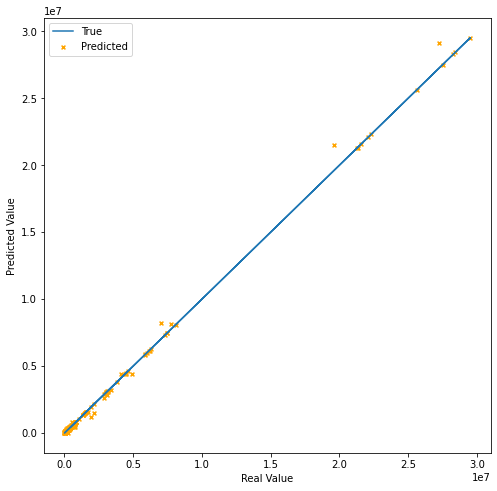

Traing R^2:  0.9999999801533095
MSE score:  374075.62486639764
Testing R^2:  0.9910278514769612


In [16]:
# plot
plt.figure(figsize=(8,8))
plt.plot(y, y, label='True')
plt.scatter(y, full_fitted,marker='x', color="orange",s = 15, label='Predicted')
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()

print("Traing R^2: ", xgb_regModel.score(X_with_p_and_onehot_train, y_train))
mse = metrics.mean_squared_error(y_train, predicted)
print('MSE score: ', mse)

#看測試集R^2

print("Testing R^2: ", xgb_regModel.score(X_with_p_and_onehot_test, y_test))


# 可解釋性模型：嘗試減少輸入的特徵值數量



## 列出XGBoost認為的重要特徵

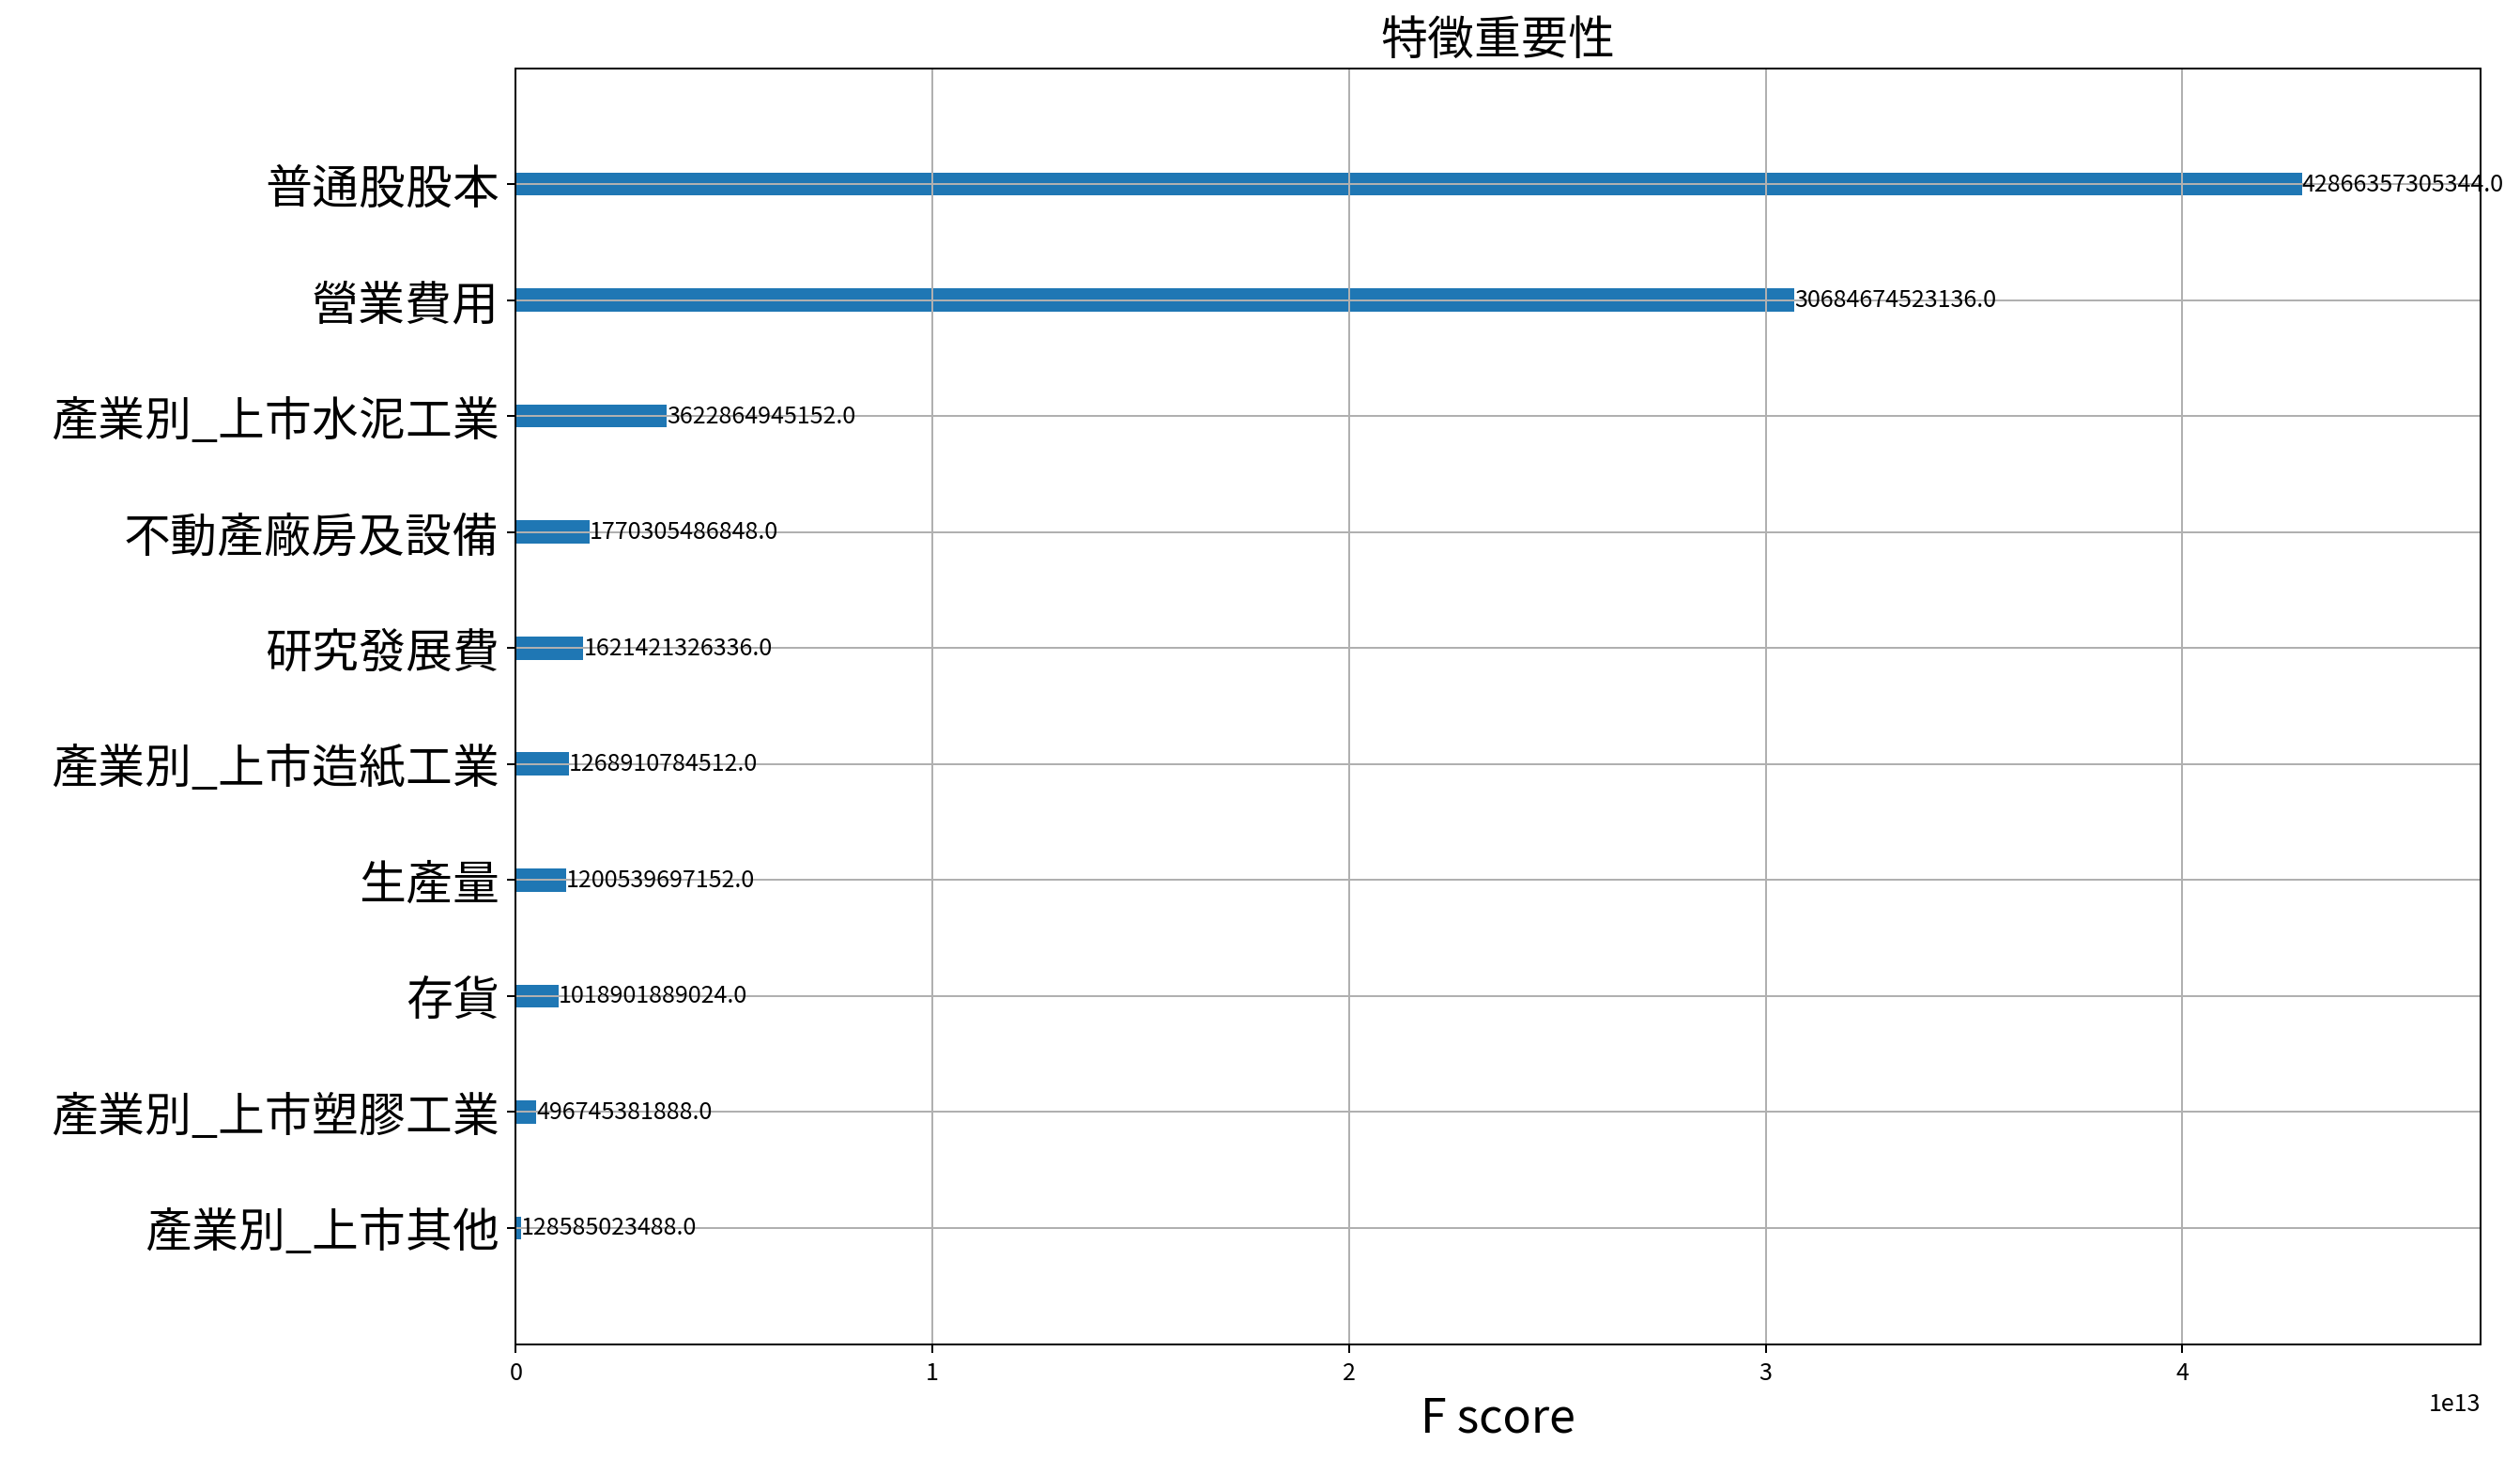

In [65]:
from xgboost import plot_importance
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
fig, ax = plt.subplots(figsize=(15, 10), dpi = 180)
plt.yticks(fontsize = 20)
xgb.plot_importance(xgb_regModel, ax=ax, 
                    importance_type='gain', #cover, weight, gain(default)
                    max_num_features=10)
plt.ylabel(" ")
plt.xlabel("F score", fontsize = 20)
plt.title("特徵重要性", fontsize = 20)
plt.show()

#### gain
> 在每棵樹中的每個特徵都對模型有info Gain，所以將這些特徵在不同樹當中的貢獻做加總後排序。

#### cover
> 這個特徵在不同樹下可以成功劃分出幾個觀察值

#### weight (frequency)
> 特徵在出現在所有樹節點的頻率。例如總共100顆樹，每顆樹有6個節點，而特徵x1總共出現19次，則weight(x1) = 0.19


In [66]:
#將重要變數取出
feature_important = xgb_regModel.get_booster().get_score(importance_type='gain')

#取出重要變數名稱
keys = list(feature_important.keys())

#取出重要變數的F score
values = list(feature_important.values())

In [67]:
df_importance_feature = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
df_importance_feature.head(10)

,score
普通股股本,4.286636e+13
營業費用,3.068467e+13
產業別_上市水泥工業,3.622865e+12
不動產廠房及設備,1.770305e+12
研究發展費,1.621421e+12
產業別_上市造紙工業,1.268911e+12
生產量,1.200540e+12
存貨,1.018902e+12
產業別_上市塑膠工業,4.967454e+11
產業別_上市其他,1.285850e+11


In [69]:
df_importance_feature.index[:7].tolist()
#df_importance_feature.index[:5].tolist()

['普通股股本', '營業費用', '產業別_上市水泥工業', '不動產廠房及設備', '研究發展費', '產業別_上市造紙工業', '生產量']

In [70]:
top_tier_list = df_importance_feature.index[:7].tolist()
#top_tier_list = df_importance_feature.index[:5].tolist()

In [71]:
#去除產業別的欄位名稱


for item in top_tier_list:
    if item[-1:] == '業':
        top_tier_list.remove(item)

#利用底線的出現刪去產業別dummy
top_tier_list = [item for item in top_tier_list if "_" not in item]  

top_tier_list

['普通股股本', '營業費用', '不動產廠房及設備', '研究發展費', '生產量']

# 討論各特徵對碳排放的正負效果

## 利用Shapley Values

> SHAP (SHapley Additive exPlanations) 是一種機器學習的可解釋方法，是博弈論大師 Lloyd Stowell Shapley 基於合作賽局理論 (cooperative game theory) 提出來解決方案，這種方法根據玩家們在遊戲中所得到的總支出，公平的分配總支出給玩家們。

ref：https://medium.com/ai-academy-taiwan/%E5%8F%AF%E8%A7%A3%E9%87%8B-ai-xai-%E7%B3%BB%E5%88%97-shap-2c600b4bdc9e


In [92]:
import shap

In [100]:
#將上方建立的xgb_regModel模型帶入shap中
feature_interpret = shap.Explainer(xgb_regModel)

#再將特徵帶入計算
shap_values = feature_interpret(X_with_productivity_and_OnehotIndustry.iloc[:, :-1])

## 呈現各特徵對個別觀察值的碳排放影響

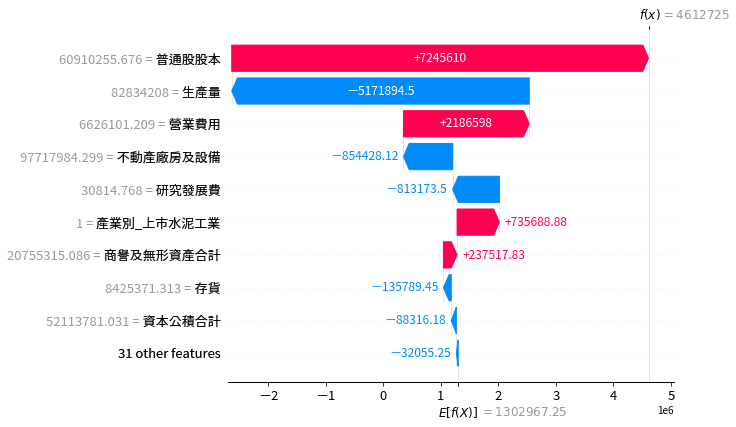

In [123]:
#以第一筆資料為例
shap.plots.waterfall(shap_values[0])

## 整體而言，這些特徵值對於碳排放量的影響

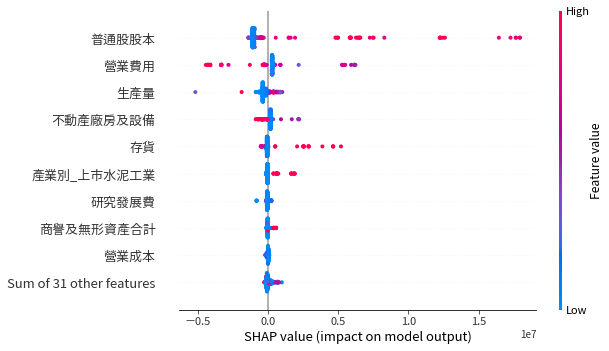

In [111]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

## 以長條圖呈現各特徵平均而言對碳排放的影響
> 可以發現透過SHAP value計算出來的特徵與XGBoost feature importance importance by info Gain有些許不同，但重複度高

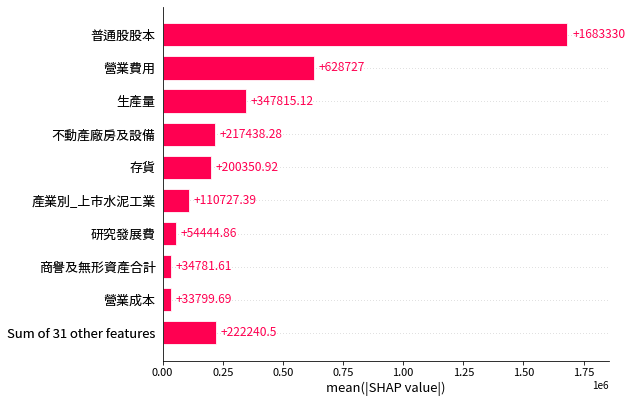

In [112]:
shap.plots.bar(shap_values)

## XGBoost Gain

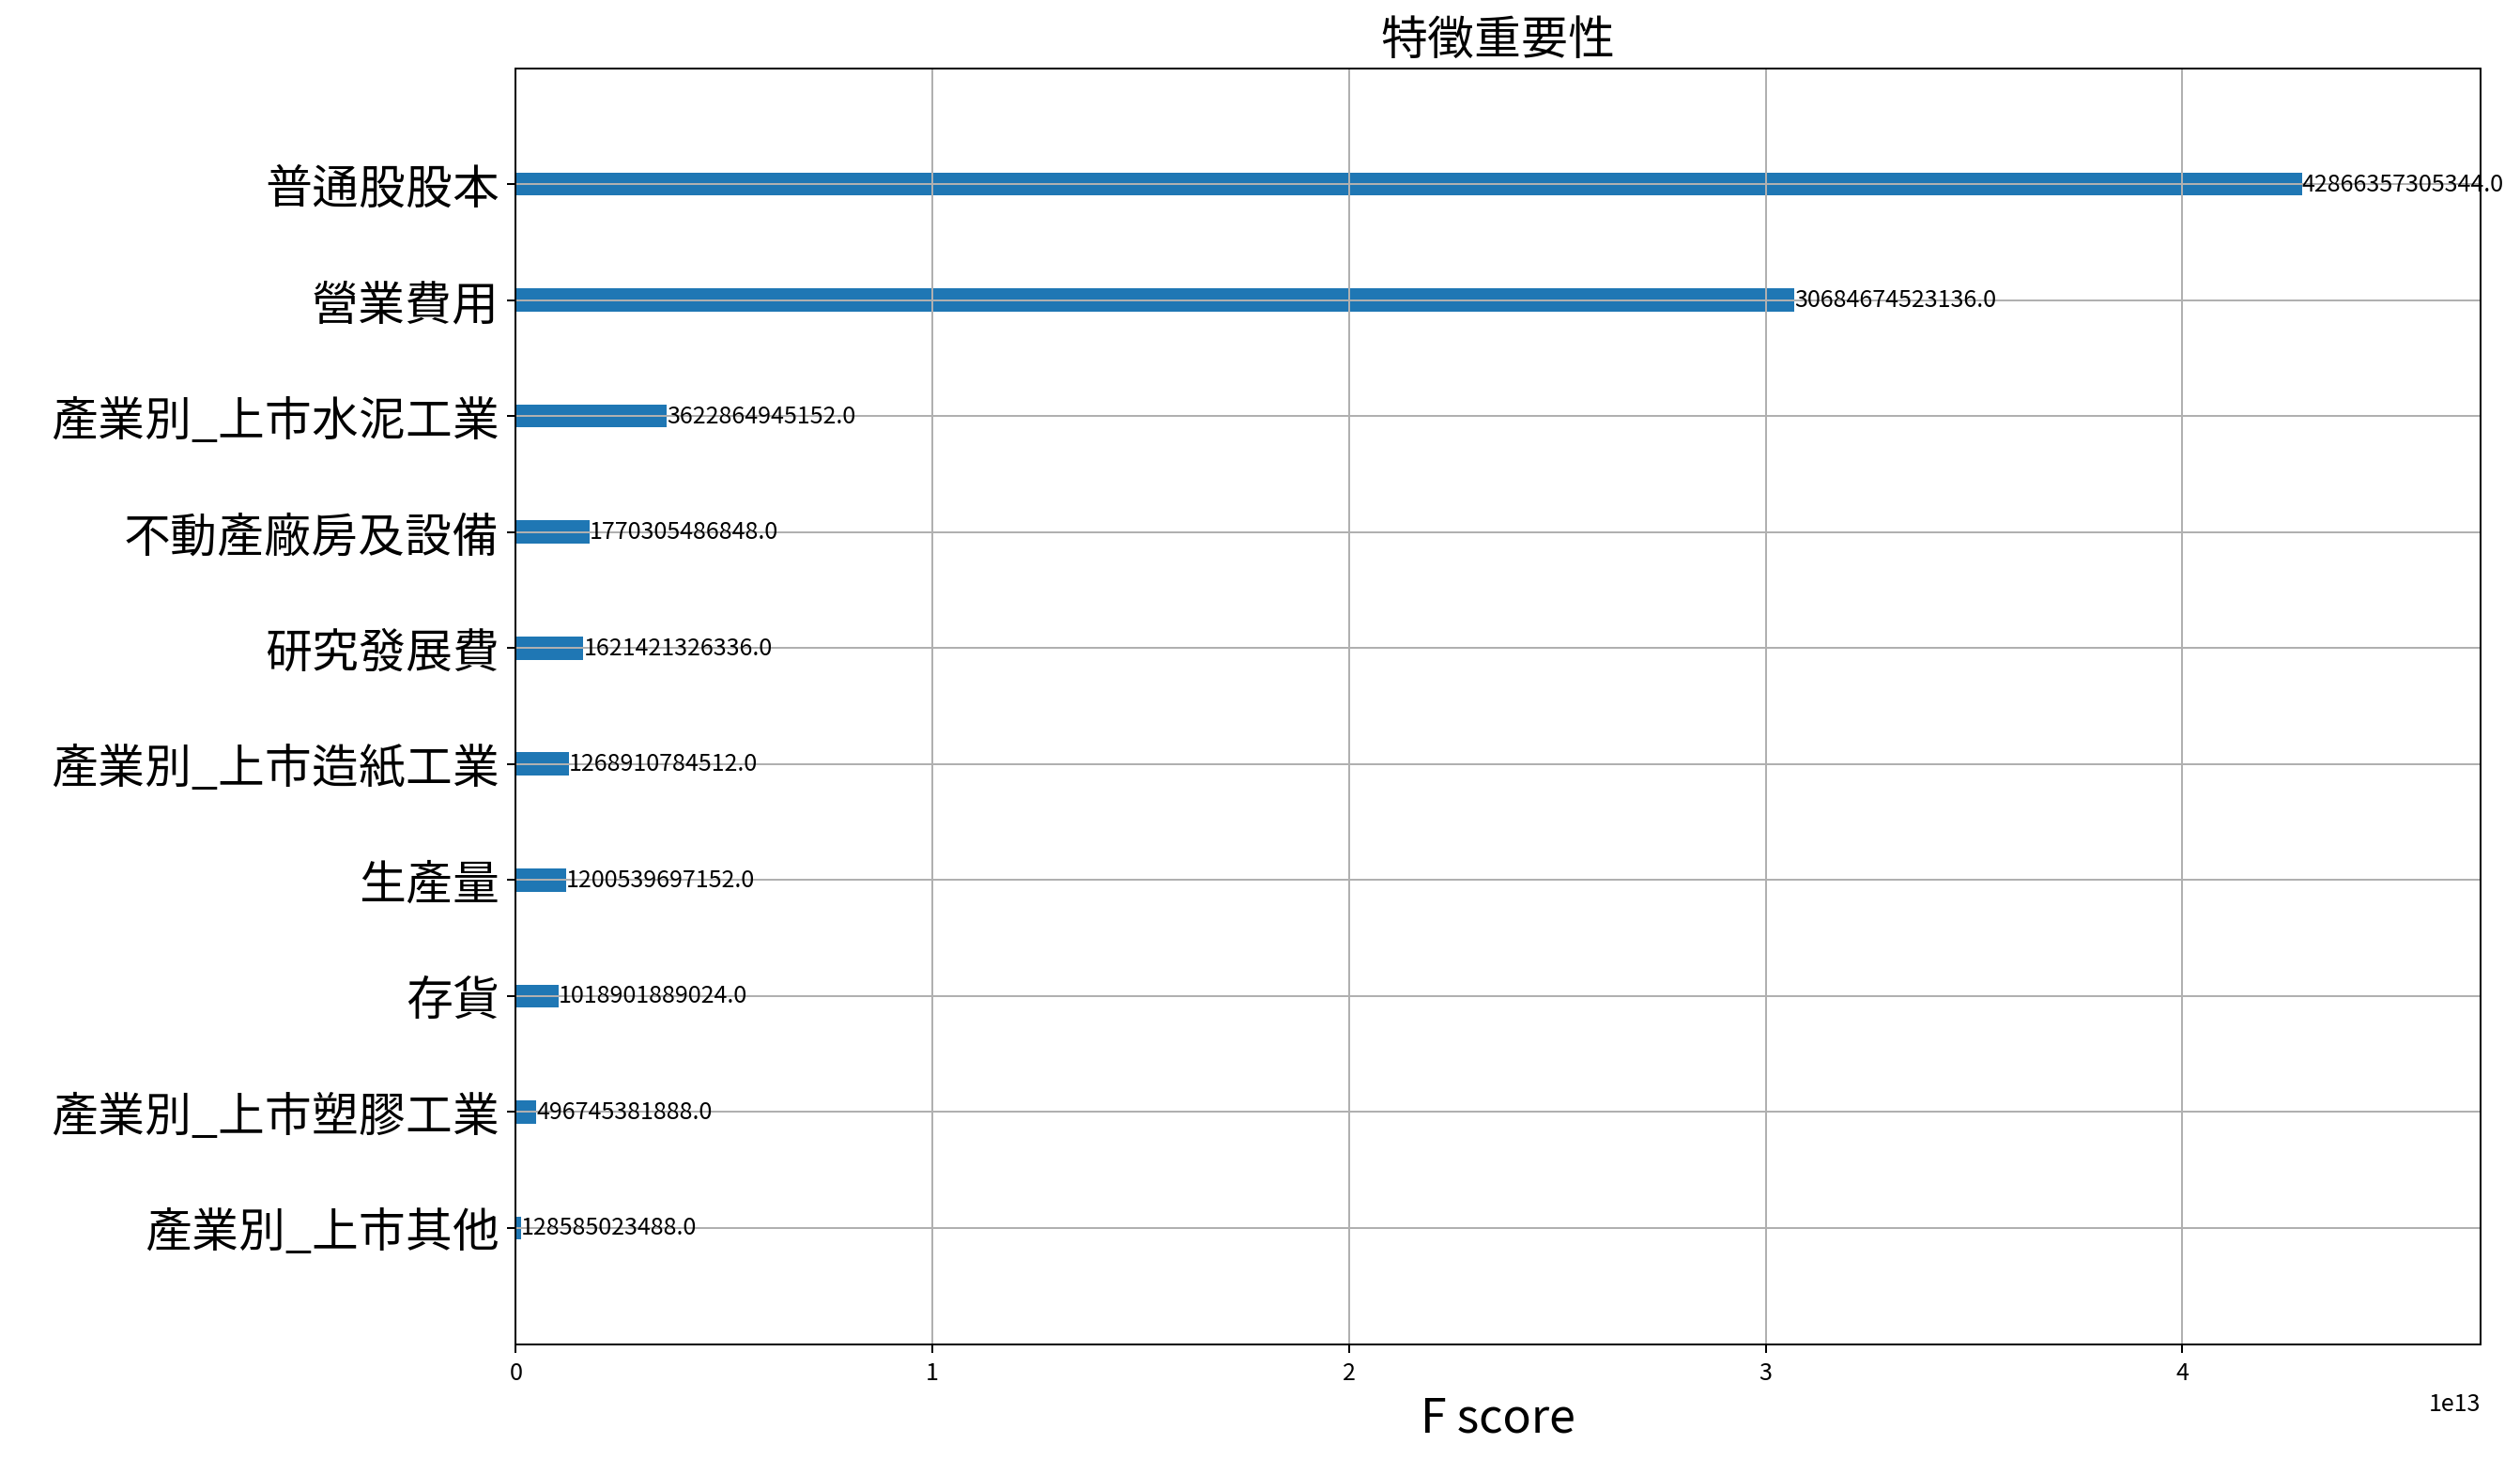

In [113]:
from xgboost import plot_importance
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
fig, ax = plt.subplots(figsize=(15, 10), dpi = 180)
plt.yticks(fontsize = 20)
xgb.plot_importance(xgb_regModel, ax=ax, 
                    importance_type='gain', #cover, weight, gain(default)
                    max_num_features=10)
plt.ylabel(" ")
plt.xlabel("F score", fontsize = 20)
plt.title("特徵重要性", fontsize = 20)
plt.show()

>嘗試只輸入這五個變數，其他數字都用平均數，還是產業平均數?

# 測試如果除了以上五個變數以外皆為均值的模型結果
>生成資料：除了上述五個以外都以產業均數的資料集

In [72]:
#先去除上述五個變數，用column數確認
features_without_top5 = X_with_productivity_and_OnehotIndustry.drop(columns = top_tier_list).columns
len(features_without_top5)

36

In [73]:
#這裡的變數皆未變成產業平均
X_mean_with_top5 = X_with_productivity_and_OnehotIndustry[features_without_top5]

In [74]:
#先加入"產業別，"方便下方groupby
X_mean_with_top5["產業別"] = 產業別

#將所有變數改為該產業平均
X_mean_with_top5[features_without_top5] = X_mean_with_top5.groupby('產業別')[features_without_top5].transform('mean')

#去除產業別，因為非數值
X_mean_with_top5 = X_mean_with_top5.drop(columns = "產業別")


In [75]:
X_mean_with_top5[top_tier_list] = data[top_tier_list]

In [76]:
X_mean_with_top5_train, X_mean_with_top5_test, y_train, y_test = train_test_split(X_mean_with_top5, y, test_size = 0.2, random_state = 0)

In [77]:
# 建立xgbrModel模型
xgb_reg_mean_with_top5_Model = xgb.XGBRegressor()

# 使用訓練資料訓練模型
xgb_reg_mean_with_top5_Model.fit(X_mean_with_top5_train, y_train)

# 使用訓練資料預測
predicted = xgb_reg_mean_with_top5_Model.predict(X_mean_with_top5_train)

print("Traing R^2: ", xgb_reg_mean_with_top5_Model.score(X_mean_with_top5_train, y_train))
mse = metrics.mean_squared_error(y_train, predicted)
print('MSE score: ', mse)

#看測試集R^2

print("Testing R^2: ", xgb_reg_mean_with_top5_Model.score(X_mean_with_top5_test, y_test))


Traing R^2:  0.9999999151523714
MSE score:  1599230.3475491034
Testing R^2:  0.991562849149958


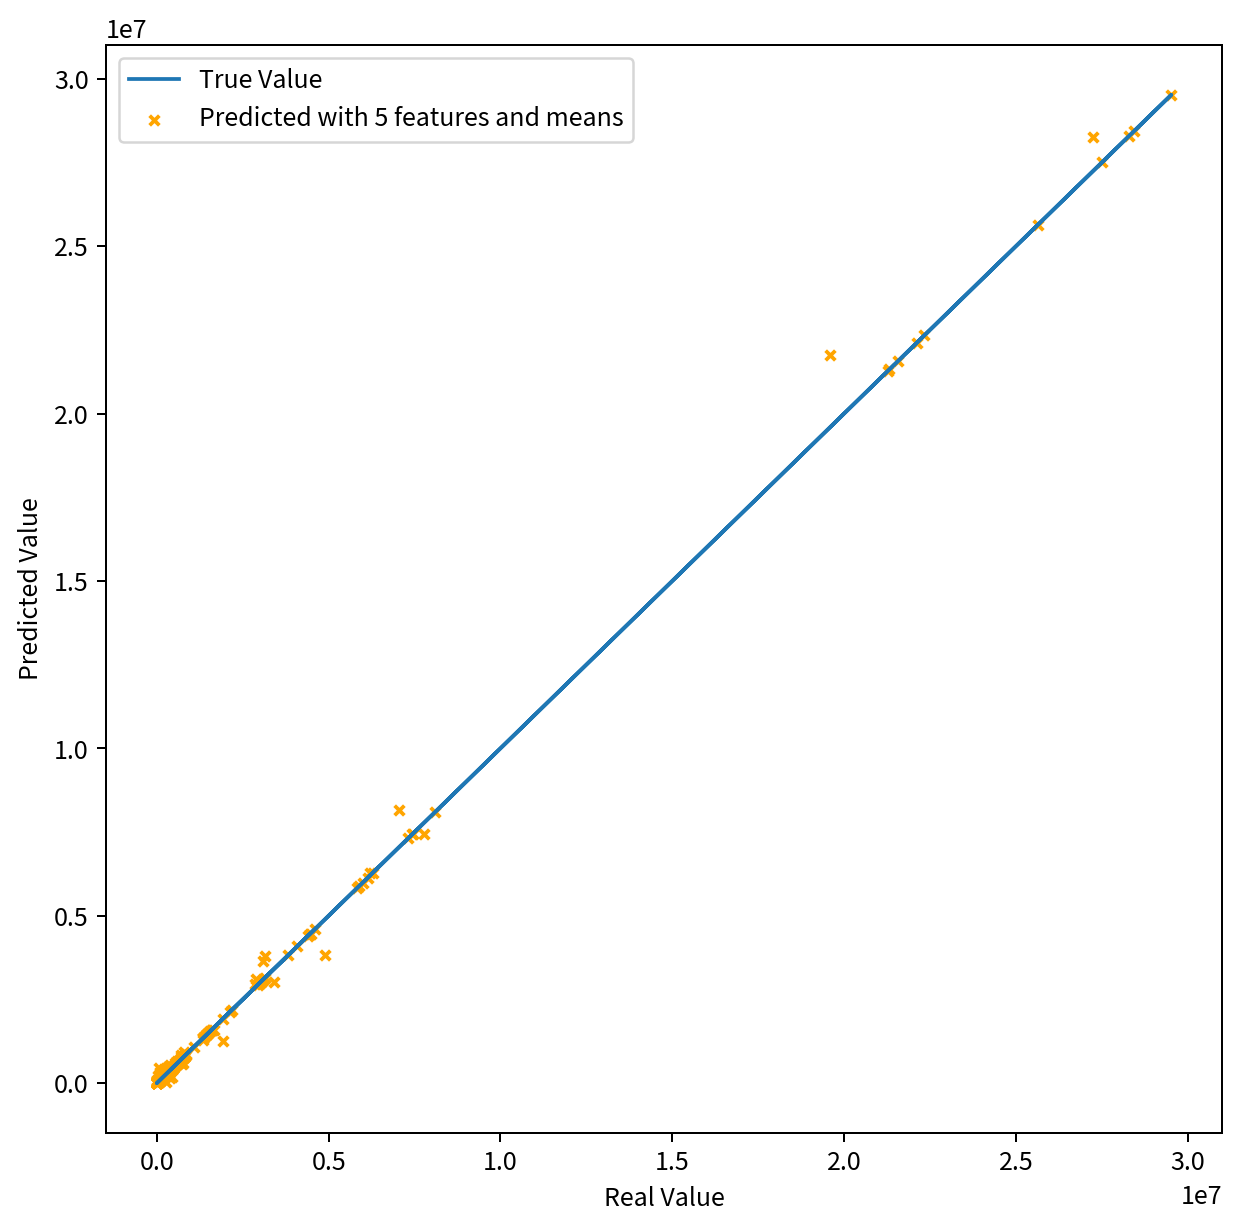

Traing R^2:  0.9999999151523714
MSE score:  1599230.3475491034
Testing R^2:  0.991562849149958


In [78]:
full_fitted = xgb_reg_mean_with_top5_Model.predict(X_mean_with_top5)

# plot
plt.figure(figsize=(8,8), dpi = 180)
plt.plot(y, y, label='True Value')
plt.scatter(y, full_fitted,marker='x', color="orange",s = 15, label='Predicted with 5 features and means')
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()

print("Traing R^2: ", xgb_reg_mean_with_top5_Model.score(X_mean_with_top5_train, y_train))
mse = metrics.mean_squared_error(y_train, predicted)
print('MSE score: ', mse)

#看測試集R^2

print("Testing R^2: ", xgb_reg_mean_with_top5_Model.score(X_mean_with_top5_test, y_test))


# 考慮只輸入五個變數

In [79]:
X_5_features = X_with_productivity_and_OnehotIndustry[top_tier_list]

In [80]:
X_5_features_train, X_5_features_test, y_train, y_test = train_test_split(X_5_features, y, test_size = 0.2, random_state = 10)

In [81]:
# 建立xgbrModel模型
xgb_reg_5_features_Model = xgb.XGBRegressor(max_depth = 18)

# 使用訓練資料訓練模型
xgb_reg_5_features_Model.fit(X_5_features_train, y_train)

# 使用訓練資料預測
predicted = xgb_reg_5_features_Model.predict(X_5_features_train)

print("Traing R^2: ", xgb_reg_5_features_Model.score(X_5_features_train, y_train))
mse = metrics.mean_squared_error(y_train, predicted)
print('MSE score: ', mse)

#看測試集R^2

print("Testing R^2: ", xgb_reg_5_features_Model.score(X_5_features_test, y_test))


Traing R^2:  0.9999999999999817
MSE score:  0.3418988178255494
Testing R^2:  0.9893640620991485


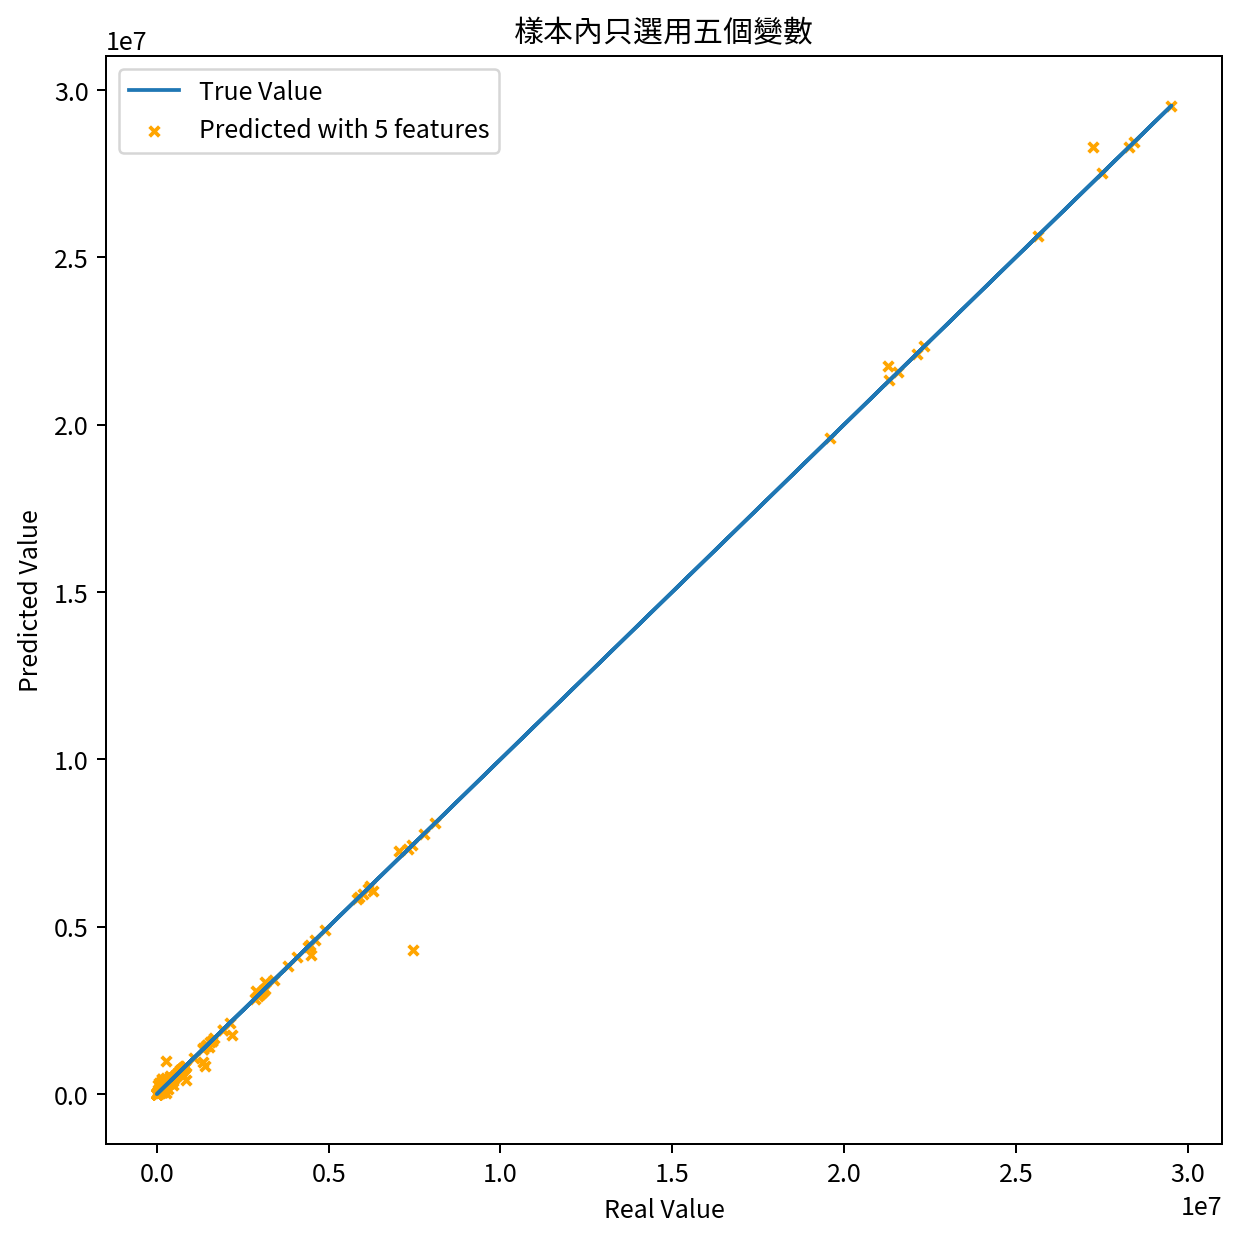

Traing R^2:  0.9999999999999817
MSE score:  0.3418988178255494
Testing R^2:  0.9893640620991485


In [82]:
full_fitted = xgb_reg_5_features_Model.predict(X_5_features)

# plot
plt.figure(figsize=(8,8), dpi = 180)
plt.plot(y, y, label='True Value')
plt.scatter(y, full_fitted,marker='x', color="orange",s = 15, label='Predicted with 5 features')
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.title("樣本內只選用五個變數")
plt.legend()
plt.show()
print("Traing R^2: ", xgb_reg_5_features_Model.score(X_5_features_train, y_train))
mse = metrics.mean_squared_error(y_train, predicted)
print('MSE score: ', mse)

#看測試集R^2

print("Testing R^2: ", xgb_reg_5_features_Model.score(X_5_features_test, y_test))

# Out-sample測試
>樣本外資料選用碳排放資料不連續，但財報資料完整的上市上櫃公司

## 資料處理

>財報平減

In [83]:
out_sample = pd.read_excel("out_sample.xlsx")
out_sample = out_sample.dropna()

In [84]:
#匯入躉售物價指數，以此指數消除不同時間點下的物價不一致性。
wpi = pd.read_csv("wpi.csv")
#生成變數，以利下方以"年"這個單位合併dataframe
wpi["date"] = pd.to_datetime(wpi["date"])
wpi["年"] = wpi["date"].dt.year

#將wpi這個df合併至TEJ這個df
out_sample = pd.merge(out_sample, wpi, how = "left", on = "年")# , suffixes=(False))
#創造平減指數
out_sample["deflator"] = out_sample["wpi index"]/100

#平減計算
out_sample.iloc[:, 5:-3] = out_sample.iloc[:, 5:-3].div(out_sample["deflator"], axis = "index")


In [85]:
X_OutSample = out_sample.iloc[:, 5:-3]
#X_OutSample["產業別"] = out_sample["產業別"]


In [86]:
#取出只有五個變數
X_OutSample_5_features = X_OutSample[top_tier_list]

In [87]:
y_OutSample = out_sample["總碳排量"]

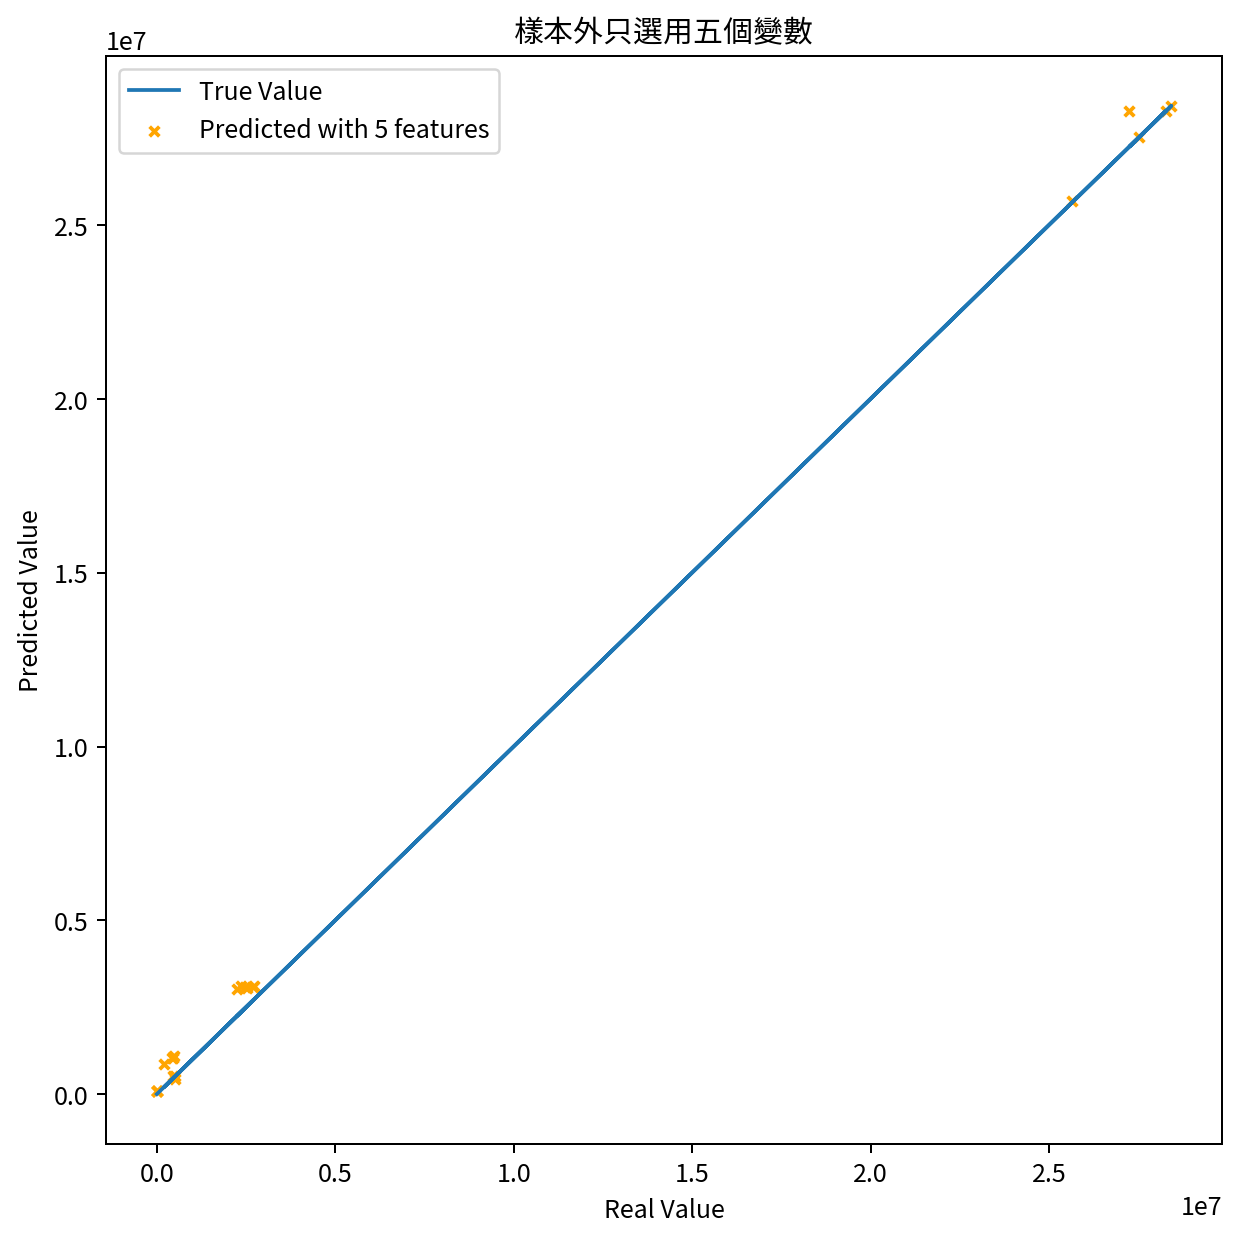

Out Sample 5 features R^2:  0.9981413044573854


In [88]:
#out Sample with only 5 figures
full_fitted_5_features = xgb_reg_5_features_Model.predict(X_OutSample_5_features)

# plot
plt.figure(figsize=(8,8), dpi = 180)
plt.plot(y_OutSample, y_OutSample, label='True Value')
plt.scatter(y_OutSample, full_fitted_5_features,marker='x', color="orange",s = 15, label='Predicted with 5 features')
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.title("樣本外只選用五個變數")
plt.legend()
plt.show()

print("Out Sample 5 features R^2: ", xgb_reg_5_features_Model.score(X_OutSample_5_features, y_OutSample))


# 預測值出現負值

## 先觀察負值出現的資料

#觀察樣本外估計值
full_fitted_5_features
#樣本外估計值無負數

df_5feats_y_yfitted = ""
df_5feats_y_yfitted = X_5_features
df_5feats_y_yfitted["y"] = y
df_5feats_y_yfitted["y_fitted"] = full_fitted

company_info = data.columns[:4]
df_5feats_y_yfitted[company_info] = data.iloc[:, :4]

#檢查是否還有負值
df_5feats_y_yfitted[(df_5feats_y_yfitted["y_fitted"] < 0)]

***
***
#### 會出現估計值為負的可能有很多，我們的問題是：
1. 資料中還有碳排為零的資料，因此先去除。
2. 去除資料後還有兩筆估計值為負的資料
3. 發現可能是樹深不夠，我從6改為7；但通常而言是樹深過深才會出現負值。


***
***

## 再測試用所有資料且含onehot

In [48]:
#另存out sample df
X_OutSample_onehot = X_OutSample

#加入產業別文字變數以利下方生成one-hot
X_OutSample_onehot['產業別'] = out_sample['產業別']

#生成one-hot encoding
#由於樣本外產業只是總樣本的一部分所以要手動生成Oone-hot
for i in 產業別.unique().tolist():
    col_name = "產業別_" + i
    X_OutSample_onehot[col_name] = ""
    for n in range(len(X_OutSample_onehot["產業別"])):
        if X_OutSample_onehot["產業別"][n] == i:
            X_OutSample_onehot[col_name][n] = int(1)
        else:
            X_OutSample_onehot[col_name][n] = int(0)
        X_OutSample_onehot[col_name] = pd.to_numeric(X_OutSample_onehot[col_name])

In [49]:
#去除非數值變數才能建立模型
X_OutSample_onehot = X_OutSample_onehot.drop(columns = ["產業別"])

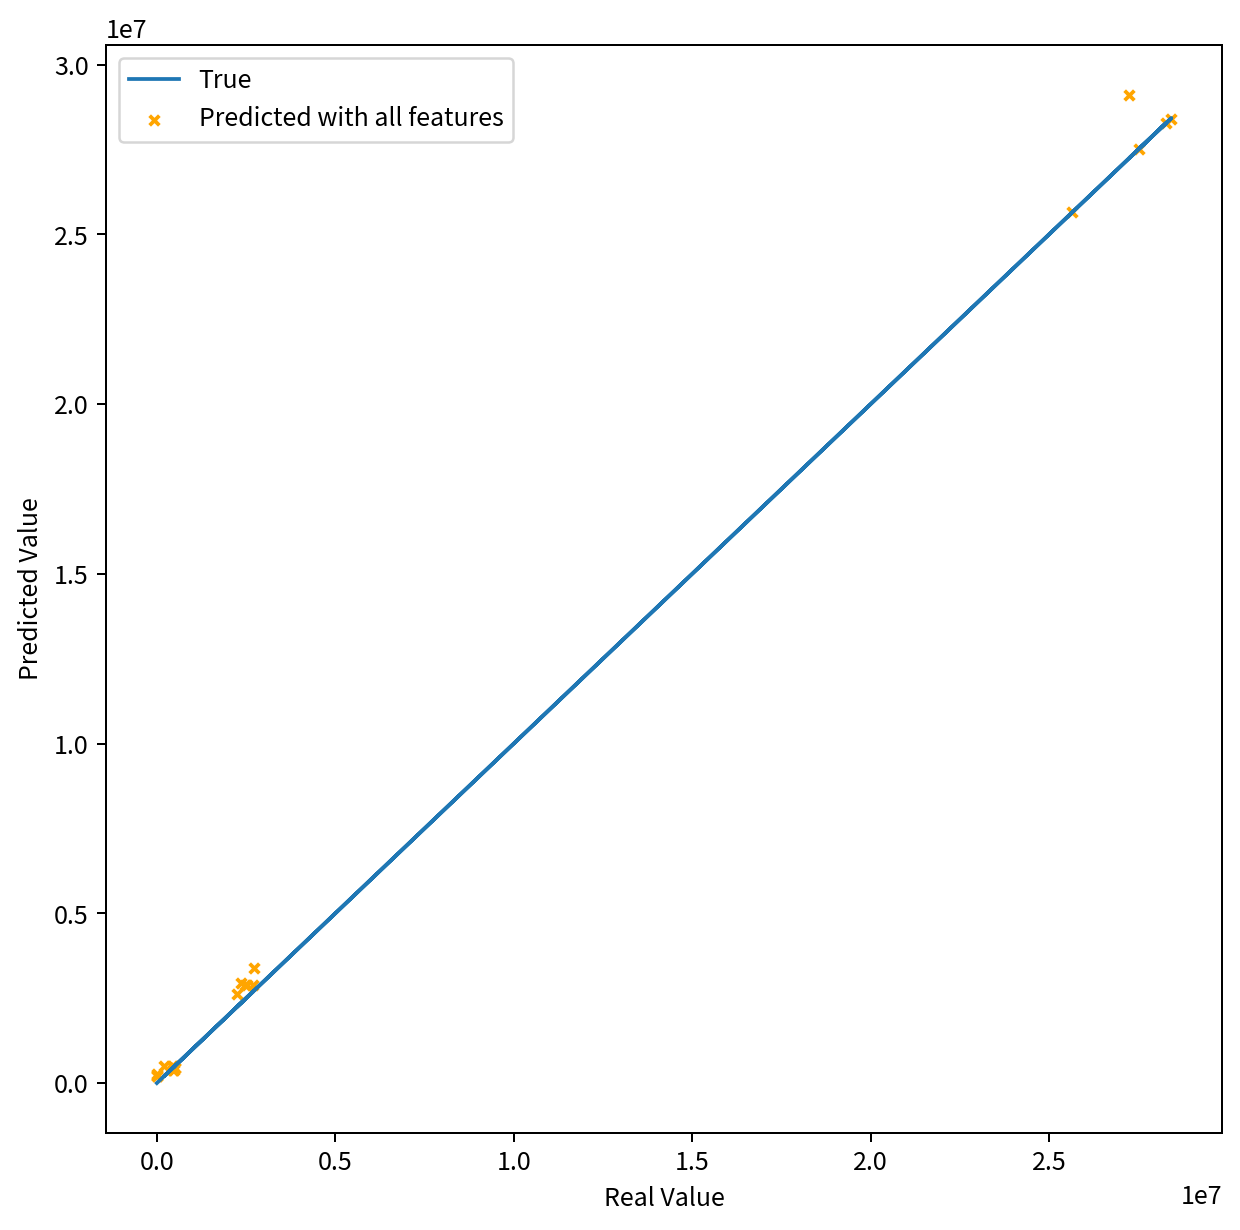

Out Sample with all features' R^2:  0.9981578698020915


In [50]:
full_fitted_FullandOnehot = xgb_regModel.predict(X_OutSample_onehot)

plt.figure(figsize=(8,8), dpi = 180)
plt.plot(y_OutSample, y_OutSample, label='True')
plt.scatter(y_OutSample, full_fitted_FullandOnehot, marker='x', color="orange",s = 15, label='Predicted with all features')
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()


#看測試集R^2
print("Out Sample with all features' R^2: ", xgb_regModel.score(X_OutSample_onehot, y_OutSample))


# 模型儲存

模型儲存
https://stackoverflow.com/questions/43691380/how-to-save-load-xgboost-model

>匯出後端資料

>能不能讓使用者選完產業後，後端先給定各產業平均值以及產業dummy?

In [52]:
#後端給定產業平均值的資料

csv_for_model_mean = X_mean_with_top5.drop(columns = top_tier_list).drop_duplicates()

In [53]:
X_median_for_pickle = X_mean_with_top5[top_tier_list]
X_median_for_pickle["產業別"] = 產業別
csv_for_model_median = X_median_for_pickle.groupby("產業別").median()

In [54]:
len(csv_for_model_median.columns)

5

In [55]:
path = r"C:\Users\hughw\Dropbox\2022 DIGI+ TALENT 工研院-智慧機械科技中心\data\\"
path.replace('\\','/')

csv_for_model_mean.to_csv(path.replace('\\','/')+"csv_for_model_mean.csv", encoding="utf_8_sig")
csv_for_model_median.to_csv(path.replace('\\','/')+"csv_for_model_median.csv", encoding="utf_8_sig")

>匯出模型

In [56]:
import pickle

#save model
pickle.dump(xgb_reg_5_features_Model, open("xgb_reg_5_features_Model.dat","wb"))

>匯入模型，進行測試

In [57]:
#load model
xgb_reg_5_features_Model_load = pickle.load(open("xgb_reg_5_features_Model.dat","rb"))

In [58]:
# 使用模型,對隨機抽取的數列randomlist轉成random_2Dnumpy再進行預測
import random
minimum = 10
maximum = 10000000000000
randomlist = []
for i in range(0, 5): #需輸入15個特徵
    n = random.randint(minimum, maximum)
    randomlist.append(n)

#key_in_data = []
#key_in_data.extend(randomlist)
#key_in_data.extend(np.zeros(24).tolist())
#key_in_data.extend(np.ones(1).tolist())


#random_2Dnumpy = np.array(key_in_data)[np.newaxis, :]
random_2Dnumpy = np.array(randomlist)[np.newaxis, :]

In [59]:
#輸入資料的時候要將資料轉為"two dimensional np array"，可見下方shape
random_2Dnumpy.shape

#注意：要把資料轉為float32

(1, 5)

In [60]:
#資料順序
X_5_features_test.columns

Index(['生產量', '存貨', '不動產廠房及設備', '應付帳款及票據', '普通股股本'], dtype='object')

In [61]:
xgb_reg_5_features_Model.predict(np.float32(random_2Dnumpy))

array([20020512.], dtype=float32)

In [62]:
xgb_reg_5_features_Model_load.predict(np.float32(random_2Dnumpy))

array([20020512.], dtype=float32)

In [63]:
xgb.__version__

'1.6.2'